Tasks
- (🗃️) Develop a software code for preprocessing the dataset, i.e., for computing the distance between different
data objects. Notice that you have to cope with binary and discrete attributes!!!
- (🌐) Develop software code for learning at least two types of clustering algorithms on the given dataset — when
clustering, ignore the following variables; Hypertension, Stroke and Diabetes
- (🔍) Develop a software code for comparing the performance of different types of clustering algorithms and/or
different instances of the same type of algortihm, i.e., when changing the parameters value (k for k-means,
eps and minpts for DBSCAN, etc...). Both supervised and unsupervised performance measures must be
made available, at least a couple of them for each class of clustering performance measures. In this case
use one by one the following three variables: Hypertension, Stroke and Diabetes, for supervised
performance evaluation.
- (🔝) Develop a software code for selecting the «optimal number of clusters», in this case different relative
measures must be made available

In [ ]:
# Choose what to run

# DISCLAIMER: default Coalb (not Pro) does not have enough RAM to run this code
#             we suggest you lower the percentage of Data (🪣 Data Sub-sampling),
#             or run it locally.
Colab = True                # set to True if running this notebook in Colab
MassiveRAM = False          # set to True if you have more than 32GB of RAM

OptimizeHierarchical = True # set to True to optimize Hierarchical clustering
OptimizeKPrototypes = True  # set to True to optimize KPrototypes clutering

In [ ]:
# specify the local directory where the dataset is found, and where to save stuff

if not Colab:
    LocalDir = 'C:/Users/Filippo/Documents/Docs/Uni/AI/First Year/Second Semester/Unsupervised Learning/Exam/'

# 😡 Python stuff

In [ ]:
# install and import libraries for Colab
if Colab:
    from google.colab import drive, files
    !pip install -q hurry.filesize
    !pip install -q scikit-learn-extra
    !pip install -q gower
    !pip install -q kmodes

# hide useless Warnings that only mess cell output
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


import numpy as np                          # numpy because numpy is life
import matplotlib.pyplot as plt             # matplotlib for cool graphs
from matplotlib.cbook import boxplot_stats
from matplotlib.ticker import MaxNLocator
import seaborn as sns                       # seaborn for even cooler graphs
import pandas as pd                         # pandas for dataset management
import time                                 # time to keep track of computational times
import os                                   # os to handle directories and files
from tqdm import tqdm                       # tqdm for cool progress bars
import pickle                               # pickle to save models

# hurry to keep track of RAM usage
from hurry.filesize import alternative, size
from hurry.filesize import size

# gower for automatic Gower Distance Matrix computation
import gower

# scipy for manual Gower Distance Matrix computation
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform as sf
# and for computing hierarchical clustering dendogram
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# sklearn for clustering stuff
from sklearn.cluster import DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.neighbors import NearestNeighbors
# and for evaluation scores
from sklearn.metrics import silhouette_score, jaccard_score
from sklearn.metrics.cluster import rand_score, fowlkes_mallows_score
from sklearn.metrics import confusion_matrix

# kmodes for a k-means algorithm that works with mixed data
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

In [ ]:
# google Colab stuff

if Colab:
    # mount drive
    drive.mount('/content/gdrive')

    gpath = '/content/gdrive/MyDrive/AI4S&T/Unsupervised Learning/UL - Exam/'

    # download Dataset
    !gdown '1IGK245qloY3LExY45NGemetkHdkvcnMv'
    # set Directory
    LocalDir = '/content/'

    # create useful folders
    !mkdir saved
    !mkdir saved/dist_matrices
    !mkdir saved/models
else:
    # create useful folders
    if not os.path.isdir(f'{LocalDir}saved'):
        os.makedirs(f'{LocalDir}saved')
        os.makedirs(f'{LocalDir}saved/dist_matrices')
        os.makedirs(f'{LocalDir}saved/models')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Downloading...
From: https://drive.google.com/uc?id=1IGK245qloY3LExY45NGemetkHdkvcnMv
To: /content/Diabetes - UL project 1.xlsx
100% 2.64M/2.64M [00:00<00:00, 77.5MB/s]
mkdir: cannot create directory ‘saved’: File exists
mkdir: cannot create directory ‘saved/dist_matrices’: File exists
mkdir: cannot create directory ‘saved/models’: File exists


In [ ]:
# specify the precision of floating point data type.
# NOTE: this drastically increases the size of the
#       the Distance Matrix in RAM and Disk
#   16 :  3.1GB (too low)
#   32 :  6.3GB (recommended)
#   64 : 12.6GB (too big)
FloatPrecision = 32
if MassiveRAM: FloatPrecision = 64
else:          FloatPrecision = 32

# 🗃️ Dataset

## 🌍 Dataset Exploration

In [ ]:
# load DataSet into panda datset
DataAll = pd.read_excel('Diabetes - UL project 1.xlsx')

[N_full, M_full] = DataAll.shape
print(f'{N_full} objects\n{M_full} attributes')

40108 objects
18 attributes


In [ ]:
# display info of the dataset
DataAll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40108 entries, 0 to 40107
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   40108 non-null  int64
 1   Sex                   40108 non-null  int64
 2   HighChol              40108 non-null  int64
 3   CholCheck             40108 non-null  int64
 4   BMI                   40108 non-null  int64
 5   Smoker                40108 non-null  int64
 6   HeartDiseaseorAttack  40108 non-null  int64
 7   PhysActivity          40108 non-null  int64
 8   Fruits                40108 non-null  int64
 9   Veggies               40108 non-null  int64
 10  HvyAlcoholConsump     40108 non-null  int64
 11  GenHlth               40108 non-null  int64
 12  MentHlth              40108 non-null  int64
 13  PhysHlth              40108 non-null  int64
 14  DiffWalk              40108 non-null  int64
 15  Diabetes              40108 non-null  int64
 16  Hype

In [ ]:
# print first 10 elements of dataset
DataAll.head(10)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Diabetes,Hypertension,Stroke
0,4,1,0,1,26,0,0,1,0,1,0,3,5,30,0,0,1,0
1,8,0,0,1,29,1,0,1,1,1,0,2,0,0,0,0,0,0
2,3,0,0,1,32,0,0,1,1,1,0,3,0,0,0,0,0,0
3,12,0,1,1,24,1,1,1,1,1,0,3,0,4,0,0,1,0
4,10,1,0,1,58,0,0,0,1,1,0,3,3,3,0,0,1,0
5,10,0,1,1,29,1,0,1,1,0,0,1,0,0,1,0,0,0
6,9,0,0,1,30,0,0,1,0,1,0,2,0,0,0,0,0,0
7,10,1,0,1,30,1,0,1,1,1,0,1,0,0,0,0,0,0
8,7,1,0,1,26,0,0,0,1,1,0,3,0,15,0,0,1,0
9,8,1,1,1,28,0,0,1,0,1,0,2,2,1,0,0,0,0


In [ ]:
# display unique values of each column
for c in DataAll.columns:
    print(f'{c}: {set(DataAll[c])}')

Age: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
Sex: {0, 1}
HighChol: {0, 1}
CholCheck: {0, 1}
BMI: {12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 84, 86, 87, 89, 92, 95, 98}
Smoker: {0, 1}
HeartDiseaseorAttack: {0, 1}
PhysActivity: {0, 1}
Fruits: {0, 1}
Veggies: {0, 1}
HvyAlcoholConsump: {0, 1}
GenHlth: {1, 2, 3, 4, 5}
MentHlth: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
PhysHlth: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
DiffWalk: {0, 1}
Diabetes: {0, 1}
Hypertension: {0, 1}
Stroke: {0, 1}


In [ ]:
# Check if there are any missing values
num_missing = DataAll.isna().sum().sum()
print(f'There are {num_missing if num_missing else "no"} missing values in the database.')

There are no missing values in the database.


In [ ]:
# check for duplicates
duplicate_rows = DataAll.duplicated()
num_duplicates = duplicate_rows.sum()
duplicated_data = DataAll[duplicate_rows]

print('Number of duplicated rows:', num_duplicates)

# we will not be removing duplicates, since the dataset does not have
# any ID variable, so multiple objects could have the same values for all
# attributes but still be associated to different points.


Number of duplicated rows: 2456


## 🪣 Data Sub-sampling

In [ ]:
# fraction of data to keep.
# 1 to use all (uses more RAM)
PercentToKeep = 0.75

# sample data from dataframe
DataReduced = DataAll.sample(frac = PercentToKeep, random_state = 0)
# re-adjust indices (not really needed)
DataReduced.reset_index

[N_red, M_red] = DataReduced.shape
print(f'{N_red} objects\n{M_red} attributes')

30081 objects
18 attributes


## 🔍 Feature Selection

Explore univariate distribution of features to check whether some features can be excluded.

In [ ]:
# support function to plot boxplot and histogram for a feature
def hist_box_plot(df, feature, fig_num):
    sns.set(color_codes = 'magma', style='whitegrid')
    sns.set_style('whitegrid', {'axes.grid' : False})
    sns.set_context(rc = {'patch.linewidth': 0.0})
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,3))
    filtered = df.loc[~np.isnan(df[feature]), feature]
    # boxplot
    a = sns.boxplot(filtered, ax = ax1, color = 'tab:blue')
    a.set(xlabel='')
    a.set(ylabel='')
    a.set(yticklabels=[])
    a.set(title='')
    # histogram
    b = sns.distplot(filtered, kde=True, hist=True, kde_kws={'linewidth': 1}, color = 'tab:blue', ax = ax2)
    b.set(xlabel='')
    b.set(ylabel='')
    b.set(yticklabels=[])
    b.set(title='')
    plt.suptitle(feature)
    plt.show()

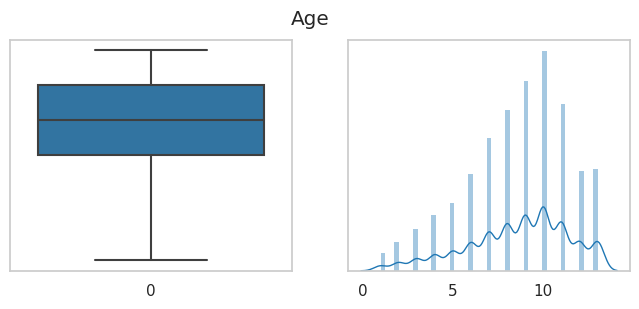

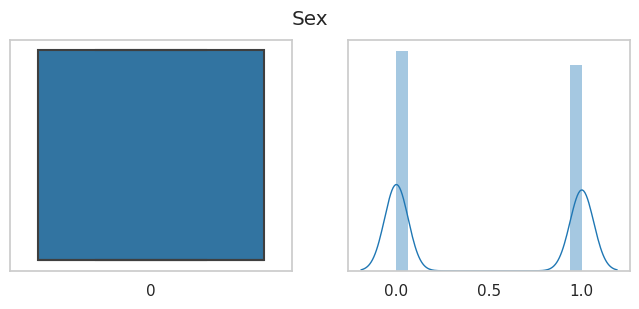

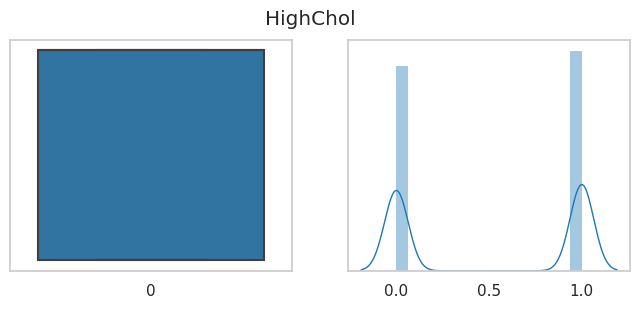

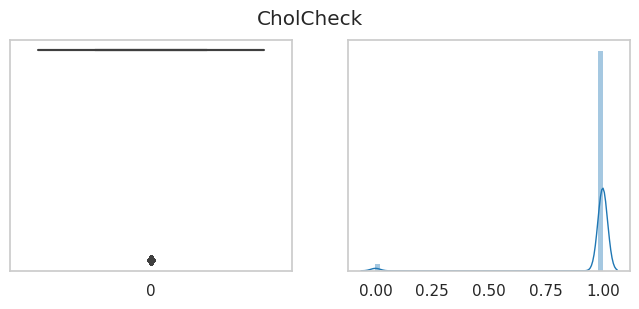

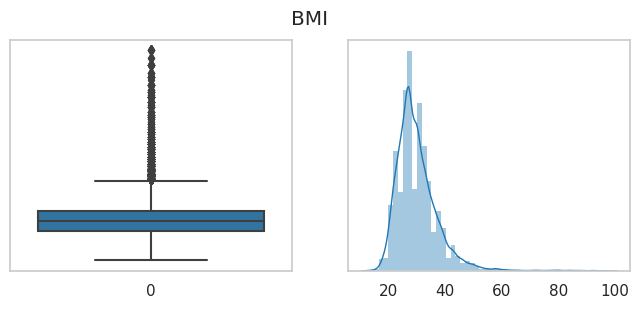

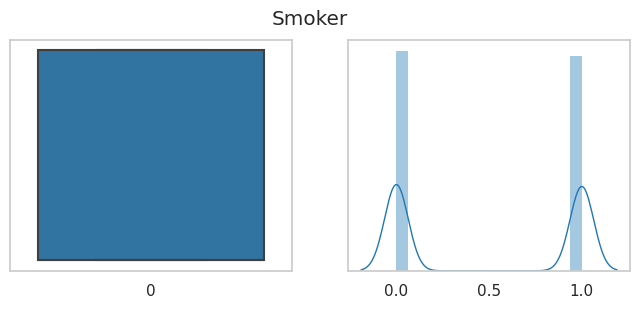

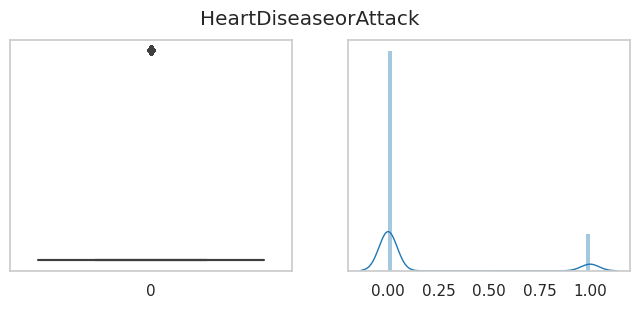

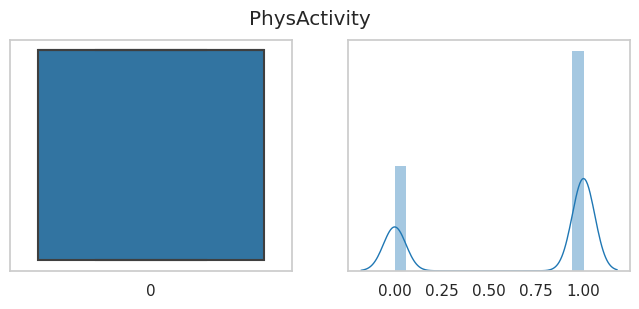

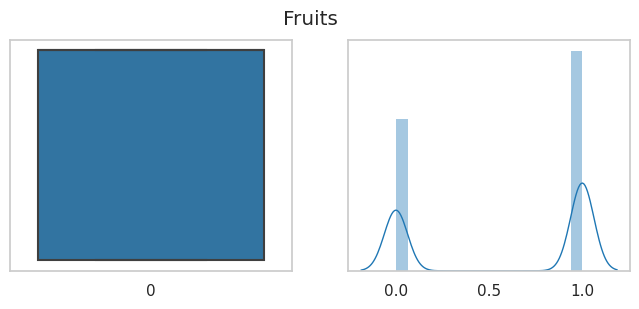

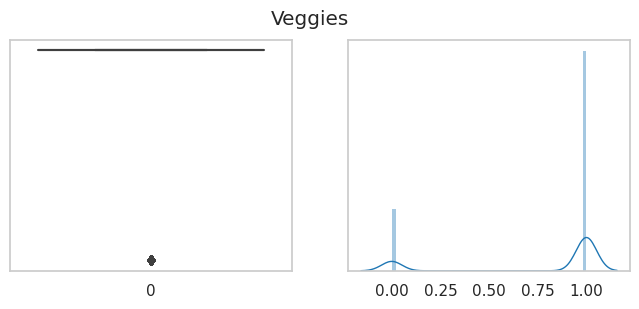

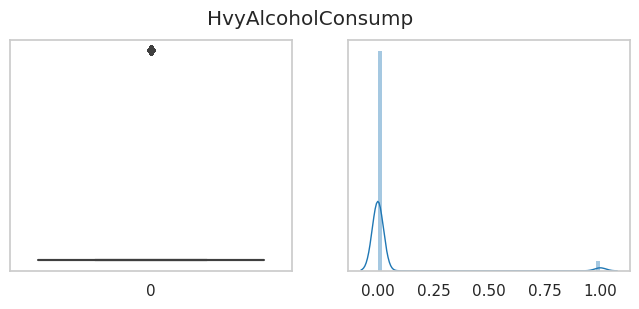

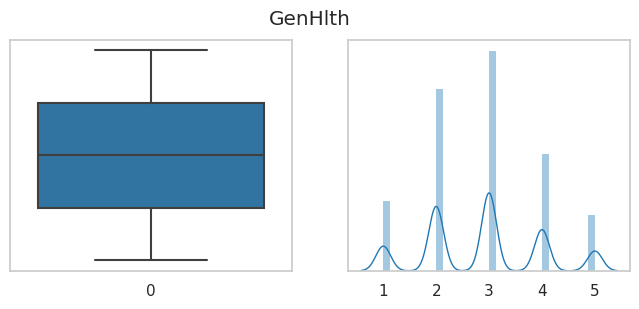

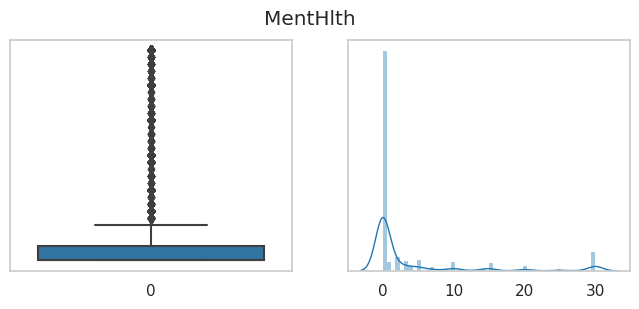

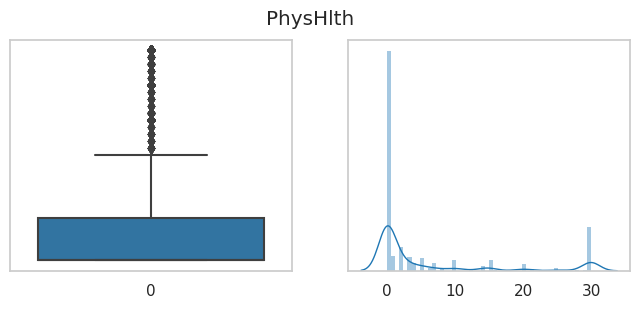

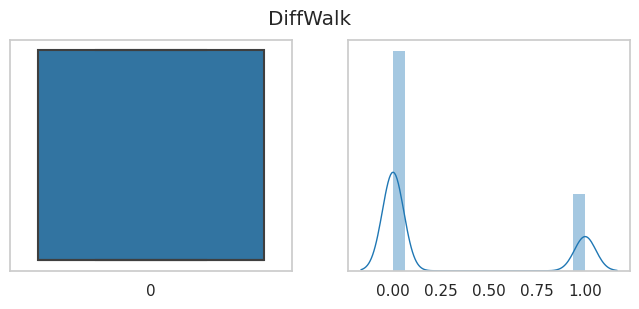

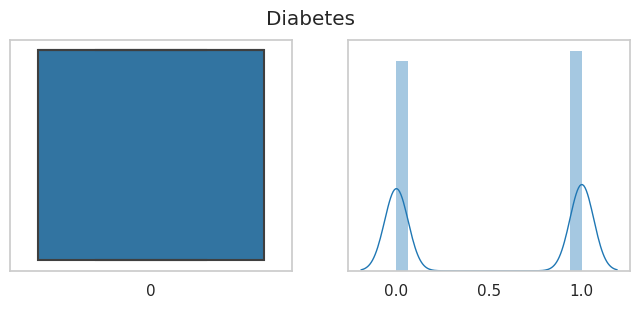

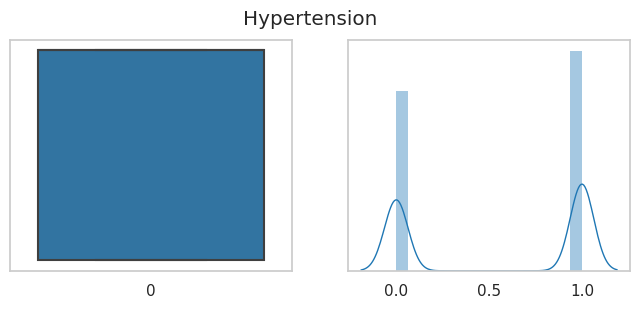

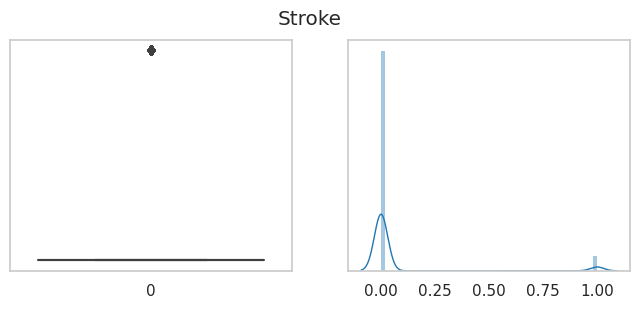

In [ ]:
# cycle over each feature and display distribution boxplot and histogram
fig_num = 1
for col in DataReduced.select_dtypes(include = [np.number]).columns:
    hist_box_plot(DataReduced, col, fig_num)
    fig_num = fig_num + 1

In [ ]:
# consider HighCol and CholCheck.
# to have a HighCol value for a patient, they would certainly need to have done a CholCheck.
# we don't have any missing values, so we decided to discard all objects with CholChcek = 0,
#                                             and to discard the CholCheck feature all-together .
DataFixed = DataReduced.copy()

# select objects with CholCheck value of 0
NoCholCheck = DataFixed[DataFixed['CholCheck'] == 0]
print(f'Objects to remove: {len(NoCholCheck)}')

# only keep objects with CholCheck value of 1
DataFixed = DataFixed[DataFixed['CholCheck'] == 1]
DataFixed = DataFixed.drop(columns = ['CholCheck'])

[N_fixed, M_fixed] = DataFixed.shape
print(f'{N_fixed} objects\n{M_fixed} attributes')

Objects to remove: 861
29220 objects
17 attributes


## 🚩 Anomaly Detection

⚖️ BMI fix


some BMI values are way too high; they are proably miss-calculated or just reported incorrectly.

(https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html)

we decided to remove objects with BMI above a certain threshold.

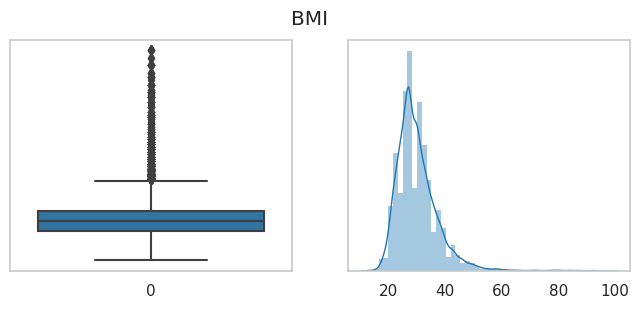

In [ ]:
# consider BMI values distribution
hist_box_plot(DataFixed, 'BMI', 1)

In [ ]:
# we can see that many points are outliers (outside of the boxplot)
# let's remove them.

# select the value of BMI after which all points are considered outliers
minOutlier = np.min(boxplot_stats(DataFixed['BMI']).pop(0)['fliers'])
print(f'If we consider values of BMI above {minOutlier} as outliers, we would exclude {len(DataFixed[DataFixed["BMI"] >= 46])} objects.')

If we consider values of BMI above 46 as outliers, we would exclude 988 objects.


In [ ]:
# Exclude points with too high values of BMI
print(f'Before: {N_fixed} objects')
DataFixed = DataFixed[DataFixed['BMI'] < minOutlier]
[N_fixed, M_fixed] = DataFixed.shape
print(f'After : {N_fixed} objects')

Before: 29220 objects
After : 28232 objects


In [ ]:
# # https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html

# # Convert BMI to categorical

# #  <19   ->   0   : underweight
# # 19-25  ->   1   : normal
# # 26-30  ->   2   : overweight
# # 31-35  ->   3   : obese
# #  >35   ->   4   : extremely obese

# BMI_map = {
#     range( 0,19): 0,
#     range(19,26): 1,
#     range(26,31): 2,
#     range(31,36): 3,
#     range(36,60): 4,

# }
# DataFixed.loc[:, 'BMI']  = DataFixed['BMI'].replace(BMI_map)

## 🅱 Datatypes

In [ ]:
# Change datatype of variables
#   nominal -> 'category'
#   ordinal -> 'int'
#   ratio   -> 'float

DataFixed['Age'] = DataFixed['Age'].astype(f'int16')
DataFixed['Sex'] = DataFixed['Sex'].astype('category')
DataFixed['HighChol'] = DataFixed['HighChol'].astype('category')
DataFixed['BMI'] = DataFixed['BMI'].astype(f'float{FloatPrecision}')
DataFixed['Smoker'] = DataFixed['Smoker'].astype('category')
DataFixed['HeartDiseaseorAttack'] = DataFixed['HeartDiseaseorAttack'].astype('category')
DataFixed['PhysActivity'] = DataFixed['PhysActivity'].astype('category')
DataFixed['Fruits'] = DataFixed['Fruits'].astype('category')
DataFixed['Veggies'] = DataFixed['Veggies'].astype('category')
DataFixed['HvyAlcoholConsump'] = DataFixed['HvyAlcoholConsump'].astype('category')
DataFixed['GenHlth'] = DataFixed['GenHlth'].astype(f'int16')
DataFixed['MentHlth'] = DataFixed['MentHlth'].astype(f'float{FloatPrecision}')
DataFixed['PhysHlth'] = DataFixed['PhysHlth'].astype(f'float{FloatPrecision}')
DataFixed['DiffWalk'] = DataFixed['DiffWalk'].astype('category')

DataFixed['Diabetes'] = DataFixed['Diabetes'].astype('category')
DataFixed['Hypertension'] = DataFixed['Hypertension'].astype('category')
DataFixed['Stroke'] = DataFixed['Stroke'].astype('category')

DataFixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28232 entries, 22763 to 27697
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Age                   28232 non-null  int16   
 1   Sex                   28232 non-null  category
 2   HighChol              28232 non-null  category
 3   BMI                   28232 non-null  float32 
 4   Smoker                28232 non-null  category
 5   HeartDiseaseorAttack  28232 non-null  category
 6   PhysActivity          28232 non-null  category
 7   Fruits                28232 non-null  category
 8   Veggies               28232 non-null  category
 9   HvyAlcoholConsump     28232 non-null  category
 10  GenHlth               28232 non-null  int16   
 11  MentHlth              28232 non-null  float32 
 12  PhysHlth              28232 non-null  float32 
 13  DiffWalk              28232 non-null  category
 14  Diabetes              28232 non-null  category
 15

## ✅ Prepare for Clustering

In [ ]:
# Exclude Hypertension, Stroke, and Diabetes from clustering
# since they will be used as target variables
Data = DataFixed.loc[:, ~ DataFixed.columns.isin(['Hypertension', 'Stroke', 'Diabetes'])]
DataSup = DataFixed.copy()

[N, M] = Data.shape

print(f'{N} objects\n{M} attributes')
Data.head()

28232 objects
14 attributes


,Age,Sex,HighChol,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk
22763,7,0,1,43.0,1,0,1,1,1,0,5,0.0,30.0,0
22840,7,1,1,33.0,0,0,1,1,1,0,3,2.0,4.0,0
12223,4,0,0,22.0,1,0,1,0,1,0,3,15.0,5.0,0
18423,10,0,0,33.0,0,0,1,0,1,0,2,0.0,0.0,0
151,4,0,0,23.0,1,0,1,0,1,1,2,0.0,0.0,0


In [ ]:
# select index of category-type columns
# note that this means both:
# - nominal (dtype 'category')
# - ordinal (dtype 'int')

categorical_col = [False for _ in range(M)]
for i, col in enumerate(Data.columns):
    if Data[col].dtype == 'category' or Data[col].dtype == f'int16' :
        categorical_col[i] = True

categorical_col_indexes = list(np.where(categorical_col)[0])
print(categorical_col)
print(categorical_col_indexes)

[True, True, True, False, True, True, True, True, True, True, True, False, False, True]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 13]


In [ ]:
# scale the data
# Initialize scaler: MinMaxScaler, StandardScaler, RobustScaler, Normalizer
scaler = MinMaxScaler(feature_range = (0,1))

# Apply the scaling to data
# bring all features to [0,1] interval
# binary features will remain unchanged
Data = scaler.fit_transform(np.array(Data))
DataSup = scaler.fit_transform(np.array(DataSup))
print(Data.shape)

(28232, 14)


## 🧮 Distance Matrix (Gower)

Compute a distance matrix for all rows for each variable in turn, using a metric that is appropriate for that type of variable. The final distance of elemnt i to element j is the (weighted) average of the distances of each variable.

- https://stats.stackexchange.com/questions/130974/how-to-use-both-binary-and-continuous-variables-together-in-clustering
- https://stats.stackexchange.com/questions/15287/hierarchical-clustering-with-mixed-type-data-what-distance-similarity-to-use/15313#15313
- https://stats.stackexchange.com/questions/32925/perform-k-means-or-its-close-kin-clustering-with-only-a-distance-matrix-not-p
- https://sites.google.com/site/dataclusteringalgorithms/kernel-k-means-clustering-algorithm
- https://medium.com/analytics-vidhya/concept-of-gowers-distance-and-it-s-application-using-python-b08cf6139ac2

In [ ]:
# custom function written by me to compute Gower distance for mixed binary and discrete data matrix
def DM_gower(X, metrics, weights = [], FloatPrecision = 32, verbose = False):
    """
    DM_gower computes the Gower Distance Matrix for a matrix with mixed data-types.

        X               : data matrix
        metrics         : dictionary of distance metric for specific datatype
        weights         : (optional) weights to associate to each attribute to give them more/less importance
        FloatPrecision  : (default = 32) specify floating point precision (float16, float32, float64). Will impact RAM usage
        verbose         : (default = False) set to True to see what the function is doing during computation

    returns the Distance Matrix of input matrix X given by Gower's distance.
    """

    # initialize Distance Matrix
    DM_gower = np.zeros((X.shape[0], X.shape[0]), f'float{FloatPrecision}')

    # if weights are not specified, set them all to 1
    if not weights:
        weights = np.array([1 for _ in range(X.shape[1])]).reshape(-1,1)

    # iterate over the columns of X, and compute Distance Matrix over each attribute
    if verbose: print(f'Attribute:')
    for ind, col in enumerate(X.columns):
        ti = time.time()
        if verbose: print(f'\t{col}')
        # set the metric for the current attribute
        metric = metrics[f'{X[col].dtype}']

        # compute Distance Matrix for the current attribute
        DM_col = sf(pdist(X[col].to_numpy().reshape(-1, 1)), metric).astype(f'float{FloatPrecision}')

        # scale the Distance Matrix between 0 and 1
        DM_col = DM_col / np.max(DM_col)

        # update DM_gower by adding the distance component of the current variable
        # multiplied by the corresponding weight
        DM_gower = np.add(DM_gower, DM_col * weights[ind])
        if verbose: print(f'\t\t ... done [{size(DM_gower.nbytes)}] ({(time.time()-ti):2}s)')

    # divide matrix by weighted sum of number of variables (to get average)
    DM_gower = np.divide(DM_gower, np.sum(weights)).astype(f'float{FloatPrecision}')

    if verbose: print(f'Done.\nSize of Distance Matrix : {size(DM_gower.nbytes)}')

    return DM_gower

In [ ]:
Manual = False  # set to True to use custom function for Gower, uses much more RAM

# metrics for each datatype (Manual only)
metrics = {
    f'category'             : 'hamming',
    f'int16'                : 'manhattan',
    f'float{FloatPrecision}': 'euclidean'
}

# if the matrix has already been saved, load it
if os.path.isfile(LocalDir + f'saved/dist_matrices/GowerDM{FloatPrecision}.npy'):
    print(f'File detected, loading ...')
    with open(LocalDir + f'saved/dist_matrices/GowerDM{FloatPrecision}.npy', 'rb') as f:
        DistanceMatrix = np.load(LocalDir + f'saved/dist_matrices/GowerDM{FloatPrecision}.npy')

# otherwise, compute it and save it
else:
    # either manually (with my custom function)
    if Manual and MassiveRAM:
        DistanceMatrix = DM_gower(Data, metrics, FloatPrecision = FloatPrecision, verbose = True).astype(f'float{FloatPrecision}')
    # or with the gower library
    else:
        DistanceMatrix = gower.gower_matrix(Data, cat_features = categorical_col)
    # save distance matrix to disk for later use
    with open(LocalDir + f'saved/dist_matrices/GowerDM{FloatPrecision}.npy', 'wb') as f:
        np.save(f, DistanceMatrix.astype(f'float{FloatPrecision}'))

File detected, loading ...


In [ ]:
# only plot if needed, it is very large and often crashes the notebook

# plot distance matrix
if False:   # change this to True to plot it
    fig = plt.figure(figsize = (20,10))
    plt.imshow(DistanceMatrix, cmap = 'magma')
    plt.xlabel('Object n.')
    plt.ylabel('Object n.')
    plt.title('Distance Matrix')
    plt.colorbar()
    plt.show()

## ❗ Outliers

Distance Matrix was needed to compute distance between points

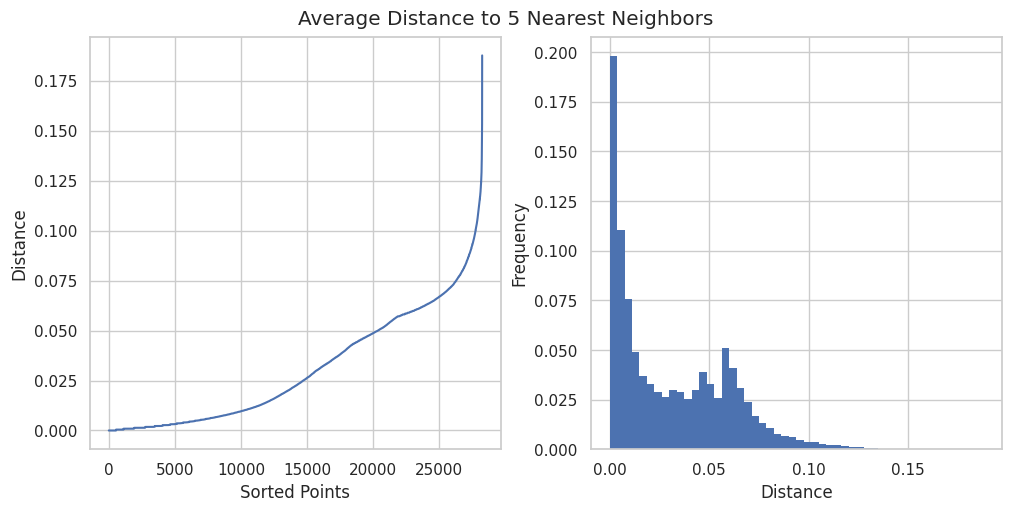

In [ ]:
# find Outliers by looking at the average of the distance of each
# point to their 5 nearest neighbors
neighborhood_order = 5
neighborhood_set   = NearestNeighbors(n_neighbors = neighborhood_order, metric = 'precomputed').fit(DistanceMatrix)
dist = neighborhood_set.kneighbors(DistanceMatrix, neighborhood_order)[0]
dist = np.mean(dist, axis = 1)

fig, ax = plt.subplots(1,2, constrained_layout = True, figsize = (10,5))
ax[0].plot(np.arange(N), np.sort(dist))
ax[0].set_xlabel('Sorted Points')
ax[0].set_ylabel('Distance')
ax[0].grid()

ax[1].hist(dist, bins = 50, weights = np.ones_like(dist) / len(dist))
ax[1].set_xlabel('Distance')
ax[1].set_ylabel('Frequency')
ax[1].grid()
fig.suptitle('Average Distance to 5 Nearest Neighbors')

plt.show()

In [ ]:
# remove points that have average distance to their 5 nearest neighbors
# higher than 0.075

to_delete = np.array(dist>0.075)
print(f'Before: {Data.shape} : {DistanceMatrix.shape}')
print(f'To delete: {np.sum(to_delete)}')

# if the matrix has already been computed, load it
if os.path.isfile(LocalDir + f'saved/dist_matrices/GowerDM{FloatPrecision}RED.npy'):
    with open(LocalDir + f'saved/dist_matrices/GowerDM{FloatPrecision}RED.npy', 'rb') as f:
        DistanceMatrix = np.load(LocalDir + f'saved/dist_matrices/GowerDM{FloatPrecision}RED.npy')

# otherwise, compute it
else:
    # remove outliers
    DistanceMatrix = np.delete(DistanceMatrix, to_delete, axis = 0)
    DistanceMatrix = np.delete(DistanceMatrix, to_delete, axis = 1)
    # save distance matrix to disk for later use
    with open(LocalDir + f'saved/dist_matrices/GowerDM{FloatPrecision}RED.npy', 'wb') as f:
        np.save(f, DistanceMatrix.astype(f'float{FloatPrecision}'))

Data = Data[~to_delete]
DataSup = DataSup[~to_delete]

print(f'After: {Data.shape} : {DistanceMatrix.shape}')
# now the distance matrix will only have inliers points

Before: (28232, 14) : (28232, 28232)
To delete: 1962
After: (26270, 14) : (26270, 26270)


In [ ]:
# only plot if needed, it is very large and often crashes the notebook

# plot reduced distance matrix
if False:
    fig = plt.figure(figsize = (20,10))
    plt.imshow(DistanceMatrix, cmap = 'magma')
    plt.xlabel('Object n.')
    plt.ylabel('Object n.')
    plt.title('Reduced Distance Matrix')
    plt.colorbar()
    plt.show()

# 🌐 Clustering

- https://scikit-learn.org/stable/modules/clustering.html

In [ ]:
with open(LocalDir + f'saved/dist_matrices/GowerDM{FloatPrecision}RED.npy', 'rb') as f:
    DistanceMatrix = np.load(LocalDir + f'saved/dist_matrices/GowerDM{FloatPrecision}RED.npy')

## 🆘 Support Functions

In [ ]:
# returns Cohesion, Separation and Silhouette scores from Distance Matrix and predicted labels
def ComputeUnsupervisedMetrics(DistanceMatrix, labels):
    num_clusters = np.max(labels)+1

    # cohesion:
    # sum of pairwise distances between points of same cluster (averaged)
    cohesions = 0

    # separation:
    # sum of pairwise distances between points of different clusterers (averaged)
    separations = 0

    # cycle over clusters
    for k in range(0, num_clusters):

        # indices of points of same cluster
        indSame = np.where(labels == k)[0]
        # indices of points of different clusters
        indDiff = np.where(labels != k)[0]

        cohesion_k = 0
        separation_k = 0

        # cycle over indices of same cluster, compute cohesion
        # as sum of pairwise distances
        for i in indSame:
            cohesion_k += DistanceMatrix[i][indSame].sum()

        # cycle over indices of different clusters, compute separation
        # as sum of pairwise distances
        for j in indDiff:
            separation_k += DistanceMatrix[j][indDiff].sum()

        # normalize for cluster size (number of connections)
        N = len(indSame)
        M = len(indDiff)
        cohesion_k = cohesion_k / (2*(N*(N+1)))
        separation_k = separation_k / (2*(M*(M+1)))

        cohesions += cohesion_k
        separations += separation_k

    cohesion = cohesions/num_clusters
    separation = separations/num_clusters

    silhouette = silhouette_score(DistanceMatrix, labels, metric = 'precomputed')

    return cohesion, separation, silhouette


## 👪 Hierarchical

In [ ]:
# Hierarchical Clustering parameters
method_merging = 'complete'

# convert square matrix form into a condensed array
DistanceArray = sf(DistanceMatrix)

# compute Linkage Matrix
LinkageMatrix = linkage(DistanceArray, method = method_merging)

### 🌲 Dendrogram

In [ ]:
# Visualize the Dendrogram of the corresponding clustering

p = 10
plt.figure(figsize = (20, 10))
dn = dendrogram(LinkageMatrix, p = p, truncate_mode = 'level')
plt.xticks([])
plt.show()

### 🔝 Number of Clusters Optimization

In [ ]:
if OptimizeHierarchical:
    # compute the optimal number of clusters in terms of SSE, SSB, and Silhouette score
    cohesion_scores_hier = []
    separation_scores_hier = []
    silhouette_scores_hier = []

    num_clusters_list = []

    # iterate through different cutting point values
    print(f'Number of Clusters: ')
    for i in np.linspace(0.8,0.98,30):
        ti = time.time()
        # compute labels at given depth
        labels_hier = fcluster(LinkageMatrix, t = i, criterion = 'distance')
        CurrNumClusters = np.max(np.array(labels_hier))

        if num_clusters_list and CurrNumClusters == num_clusters_list[-1]:
            continue
        else:
            print(f'\t{CurrNumClusters}', end = '')

        # For some reason, Hierarchical clustering sets labels starting from 1.
        # we hate that, so we change it to start from 0.
        labels_hier = np.array(labels_hier)-1

        # compute Cohesion, Separation, and Silhouette Scores
        cohesion_hier, separation_hier, silhouette_hier = ComputeUnsupervisedMetrics(DistanceMatrix, labels_hier)

        cohesion_scores_hier.append(cohesion_hier)
        separation_scores_hier.append(separation_hier)
        silhouette_scores_hier.append(silhouette_hier)

        num_clusters_list.append(CurrNumClusters)

        print(f' ({time.time()-ti:4}s)')

In [ ]:
if OptimizeHierarchical:
    # plot scores for each target variable over different cutting points
    fig, ax = plt.subplots(2,1, constrained_layout = True)

    ax[0].plot(num_clusters_list, cohesion_scores_hier, label = 'Cohesion', color = 'tab:blue')
    ax[0].scatter(num_clusters_list, cohesion_scores_hier, color = 'tab:blue')
    ax[0].plot(num_clusters_list, separation_scores_hier, label = 'Separation', color = 'tab:orange')
    ax[0].scatter(num_clusters_list, separation_scores_hier, color = 'tab:orange')
    ax[0].set_ylabel('Score')
    ax[0].xaxis.set_tick_params(labelbottom=False)
    ax[0].legend(loc = 'lower left')
    ax[0].grid()

    ax[1].plot(num_clusters_list, silhouette_scores_hier, label = 'Silhouette', color = 'tab:green')
    ax[1].scatter(num_clusters_list, silhouette_scores_hier, color = 'tab:green')
    ax[1].set_xlabel('Num of Clusters')
    ax[1].set_ylabel('Score')
    ax[1].legend(loc = 'lower left')
    ax[1].grid()

    plt.show()

### 🥇 Best Model

In [ ]:
# Cut the dendrogram at a specified max depth
MaxDepth = 0.973

# Form the clusters
labels_hier = fcluster(LinkageMatrix, t = MaxDepth, criterion = 'distance')
labels_hier = np.array(labels_hier)-1
print(f'Hierarchical Clusters: {set(labels_hier)}')

# Add a horizontal line to the dendrogram indicating the cut
p = 7
plt.figure(figsize=(20, 10))
dn = dendrogram(LinkageMatrix, color_threshold = MaxDepth, p = p, truncate_mode = 'level')
plt.axhline(y = MaxDepth, color = 'tab:red', linestyle = 'dashed')
plt.xticks([])
plt.show()

In [ ]:
# display distribution of labels
plt.hist(labels_hier, weights = np.ones_like(labels_hier)/len(labels_hier))
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Points in Clusters')
plt.plot()

print('Fraction in cluster 1 ', np.sum(labels_hier) / len(labels_hier))

## 💠 k-prototypes

https://pypi.org/project/kmodes/

https://medium.com/@keswani-rohitkumar/k-prototypes-clustering-algorithm-f5d8e09a0104

- k-modes:        ALL categorical
- k-prototypes:   MIXED

### 🏁 Num of initializations optimization

In [ ]:
if OptimizeKPrototypes:
    # run the same model 20 times (for both huang and cao)
    # to see how much initialization influences the result,
    # and change n_init accordingly

    vars_cao = []
    vars_huang = []
    best_cao = []
    best_huang = []

    # cycle over different number of initializations
    for n_init in tqdm(range(1,10)):
        costs_cao = []
        costs_huang = []

        # run each model 20 times
        for n_runs in range(20):
            # initialize KPrototypes model
            model_kproto_cao = KPrototypes(n_clusters = 2, init = 'Cao', n_init = n_init, n_jobs = -1)
            model_kproto_huang = KPrototypes(n_clusters = 2, init = 'Huang', n_init = n_init, n_jobs = -1)

            # fit the model with data matrix, specifying which are the categorical features
            kproto_cao = model_kproto_cao.fit(Data, categorical = categorical_col_indexes)
            kproto_huang = model_kproto_huang.fit(Data, categorical = categorical_col_indexes)

            # save clustering cost
            costs_cao.append(model_kproto_cao.cost_)
            costs_huang.append(model_kproto_huang.cost_)

        vars_cao.append(np.var(costs_cao))
        vars_huang.append(np.var(costs_huang))
        best_cao.append(np.mean(costs_cao))
        best_huang.append(np.mean(costs_huang))

        print()

In [ ]:
if OptimizeKPrototypes:
    # plot mean and variance of costs over different number of initializations
    fig, axs = plt.subplots(2,1, constrained_layout = True)

    axs[0].plot(range(1,10), best_cao, label = ' Cao', color = 'tab:blue')
    axs[0].scatter(range(1,10), best_cao, color = 'tab:blue')
    axs[0].plot(range(1,10), best_huang, label = 'Huang', color = 'tab:orange')
    axs[0].scatter(range(1,10), best_huang, color = 'tab:orange')
    # axs[0].set_xlabel('Num initializations')
    axs[0].xaxis.set_tick_params(labelbottom=False)
    axs[0].set_ylabel('Mean')
    axs[0].grid()
    axs[0].legend()

    axs[1].plot(range(1,10), vars_cao, label = 'Cao', color = 'tab:blue')
    axs[1].scatter(range(1,10), vars_cao, color = 'tab:blue')
    axs[1].plot(range(1,10), vars_huang, label = 'Huang', color = 'tab:orange')
    axs[1].scatter(range(1,10), vars_huang, color = 'tab:orange')
    axs[1].set_xlabel('Num initializations')
    axs[1].set_ylabel('Variance')
    axs[1].grid()
    axs[1].legend()

    plt.show()

    # Best initialization
    i_cao = np.argmin(best_cao)
    print('Cao: ', best_cao[i_cao], ' +- ', np.sqrt(vars_cao[i_cao] / 20))

    i_huang = np.argmin(best_huang)
    print('Huang: ', best_huang[i_huang], ' +- ', np.sqrt(vars_huang[i_huang] / 20))

### 🔝 Number of Clusters Optimization

In [ ]:
if OptimizeKPrototypes:
    # compute cost over different number of clusters
    costs_kproto = []
    cohesion_scores_kproto = []
    separation_scores_kproto = []
    silhouette_scores_kproto = []

    # cycle over different number of clusters number
    for n in tqdm(range(2,16)):
        # initialize KPrototypes model
        model_kproto = KPrototypes(n_clusters = n, init = 'Huang', n_init = 6, n_jobs = -1, verbose = 0)

        # fit the model with data matrix, specifying which are the categorical features
        kproto = model_kproto.fit(Data, categorical = categorical_col_indexes)

        # save clustering cost
        costs_kproto.append(model_kproto.cost_)

        # compute predicted labels
        labels_kproto = model_kproto.predict(Data, categorical = categorical_col_indexes)

        # compute Cohesion, Separation, and Silhouette Scores
        cohesion_kproto, separation_kproto, silhouette_kproto = ComputeUnsupervisedMetrics(DistanceMatrix, labels_kproto)

        cohesion_scores_kproto.append(cohesion_kproto)
        separation_scores_kproto.append(separation_kproto)
        silhouette_scores_kproto.append(silhouette_kproto)

In [ ]:
if OptimizeKPrototypes:
    # plot scores for each target variable over different number of clusters
    fig, ax = plt.subplots(3,1, constrained_layout = True)

    ax[0].plot(np.arange(len(costs_kproto))+2, costs_kproto, label = 'Cost', color = 'tab:red')
    ax[0].scatter(np.arange(len(costs_kproto))+2, costs_kproto, color = 'tab:red')
    ax[0].xaxis.set_tick_params(labelbottom=False)
    ax[0].set_ylabel('Cost', labelpad = 2)
    ax[0].legend(loc = 'lower left')
    ax[0].grid()

    ax[1].plot(np.arange(len(costs_kproto))+2, cohesion_scores_kproto, label = 'Cohesion', color = 'tab:blue')
    ax[1].scatter(np.arange(len(costs_kproto))+2, cohesion_scores_kproto, color = 'tab:blue')
    ax[1].plot(np.arange(len(costs_kproto))+2, separation_scores_kproto, label = 'Separation', color = 'tab:orange')
    ax[1].scatter(np.arange(len(costs_kproto))+2, separation_scores_kproto, color = 'tab:orange')
    ax[1].xaxis.set_tick_params(labelbottom=False)
    ax[1].set_ylabel('SSE/SSB', labelpad = 10)
    ax[1].legend(loc = 'lower left')
    ax[1].grid()

    ax[2].plot(np.arange(len(costs_kproto))+2, silhouette_scores_kproto, label = 'Silhouette', color = 'tab:green')
    ax[2].scatter(np.arange(len(costs_kproto))+2, silhouette_scores_kproto, color = 'tab:green')
    ax[2].set_xlabel('Num of Clusters')
    ax[2].set_ylabel('Silhouette', labelpad = 15)
    ax[2].legend(loc = 'lower left')
    ax[2].grid()

    plt.show()

### 🥇 Best Model

In [ ]:
# Best Parameters:
NClusters = 2
InitMethod = 'Huang'
NInit = 6

# set to True if you have a pre-trained model
# MAKE SURE TO HAVE IT IN /saved/models/
# NAMED kproto.pkl
Load = False

In [ ]:
# initialize KPrototypes model
model_kproto = KPrototypes(n_clusters = NClusters,
                            init = InitMethod,
                            n_init = NInit,
                            n_jobs = -1)

if Load:
   with open(f'{LocalDir}saved/models/kproto.pkl', 'rb') as f:
        kproto = pickle.load(f)
else:
    # fit the model with data matrix, specifying which are the categorical features
    kproto = model_kproto.fit(Data, categorical = categorical_col_indexes)
    with open(f'{LocalDir}saved/models/kproto.pkl', 'wb') as f:
        pickle.dump(kproto, f)

# save clustering cost, defined as the sum distance of all points to their respective cluster centroids.
cost_kproto = kproto.cost_

# compute labels for data matrix
labels_kproto = model_kproto.predict(Data, categorical = categorical_col_indexes)

Fraction in cluster 1  0.8252759802055577


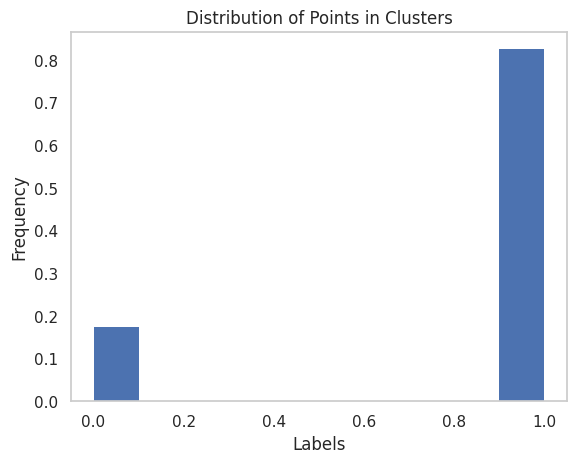

In [ ]:
# display distribution of labels
plt.hist(labels_kproto, weights = np.ones_like(labels_kproto)/len(labels_kproto))
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Points in Clusters')
plt.plot()

print('Fraction in cluster 1 ', np.sum(labels_kproto) / len(labels_kproto))

# 🔍 Evaluation - Supervised

In [ ]:
# Hierarchical

# Compute Rand Score
RDiab_hier = rand_score(labels_hier, DataSup[:,-3])
RHyper_hier = rand_score(labels_hier, DataSup[:,-2])
RStroke_hier = rand_score(labels_hier, DataSup[:,-1])

# Compute Fowlkes-Mallows Score
FMDiab_hier = fowlkes_mallows_score(labels_hier, DataSup[:,-3])
FMHyper_hier = fowlkes_mallows_score(labels_hier, DataSup[:,-2])
FMStroke_hier = fowlkes_mallows_score(labels_hier, DataSup[:,-1])

print(f'Rand Score:')
print(f'\tDiabetes:\t{RDiab_hier}')
print(f'\tHypertension:\t{RHyper_hier}')
print(f'\tStroke:\t\t{RStroke_hier}')
print(f'Fowlkes-Mallows:')
print(f'\tDiabetes:\t{FMDiab_hier}')
print(f'\tHypertension:\t{FMHyper_hier}')
print(f'\tStroke:\t\t{FMStroke_hier}')

In [ ]:
# k-prototype

# Compute Rand Score
RDiab_kproto = rand_score(labels_kproto, DataSup[:,-3])
RHyper_kproto = rand_score(labels_kproto, DataSup[:,-2])
RStroke_kproto = rand_score(labels_kproto, DataSup[:,-1])

# Compute Fowlkes-Mallows Score
FMDiab_kproto = fowlkes_mallows_score(labels_kproto, DataSup[:,-3])
FMHyper_kproto = fowlkes_mallows_score(labels_kproto, DataSup[:,-2])
FMStroke_kproto = fowlkes_mallows_score(labels_kproto, DataSup[:,-1])

print(f'Rand Score:')
print(f'\tDiabetes:\t{RDiab_kproto}')
print(f'\tHypertension:\t{RHyper_kproto}')
print(f'\tStroke:\t\t{RStroke_kproto}')
print(f'Fowlkes-Mallows:')
print(f'\tDiabetes:\t{FMDiab_kproto}')
print(f'\tHypertension:\t{FMHyper_kproto}')
print(f'\tStroke:\t\t{FMStroke_kproto}')

Rand Score:
	Diabetes:	0.5147837453393351
	Hypertension:	0.504168278118937
	Stroke:		0.7030674713984822
Fowlkes-Mallows:
	Diabetes:	0.6088845655806245
	Hypertension:	0.6008988080920385
	Stroke:		0.8194153719176396


In [ ]:
# utility functions to compute precision and recall

def precision_recall(gts, pred, target_name):
    tn, fp, fn, tp = confusion_matrix(gts, pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    heights = [tn, fn, tp, fp]
    positions = [-0.1, 0, 0.3, 0.4]

    plt.bar(positions, heights, width=0.1, align = 'center',
            color = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange'])

    plt.ylabel('Count')

    plt.xticks(positions, ['TN', 'FN', 'TP', 'FP'])

    plt.title(f'Confusion Matrix for {target_name}')

    plt.xlim(-0.2, 0.5)
    plt.ylim(0, max(heights) + 1000)

    plt.xticks([-0.05, 0.35], ['0', '1'] , minor=True)
    plt.tick_params(axis='x', which='minor', pad=20)

    plt.show()

    return precision, recall

def print_recall_precision(DataSup, pred):
    precision_diab, recall_diab = precision_recall(DataSup[:,-3], pred, 'Diabetes')
    precision_hyper, recall_hyper = precision_recall(DataSup[:,-2], pred, 'Hypertension')
    precision_stroke, recall_stroke = precision_recall(DataSup[:,-1], pred, 'Stroke')
    print(f'Diabetes:\n\tPrecision: {precision_diab:.3f}\n\tRecall: {recall_diab:.3f}')
    print(f'Hypertension:\n\tPrecision: {precision_hyper:.3f}\n\tRecall: {recall_hyper:.3f}')
    print(f'Stroke:\n\tPrecision: {precision_stroke:.3f}\n\tRecall: {recall_stroke:.3f}')

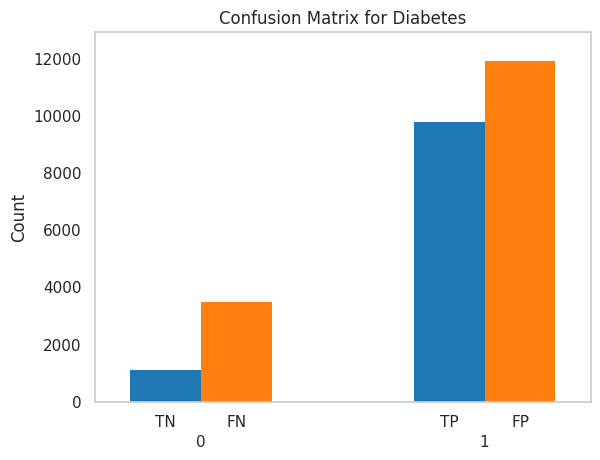

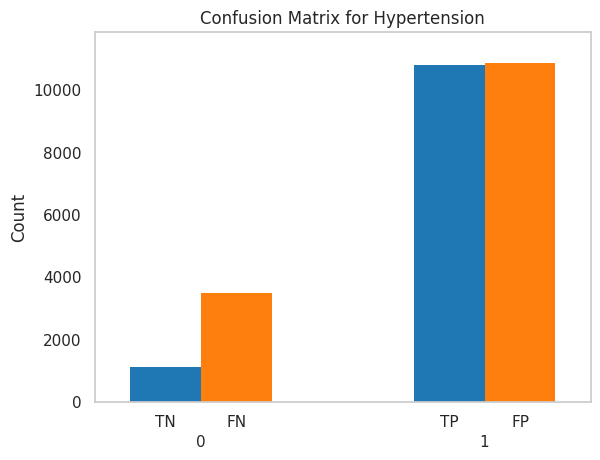

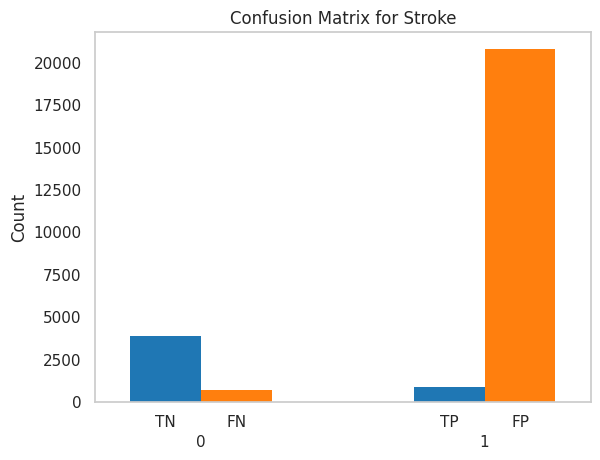

Diabetes:
	Precision: 0.450
	Recall: 0.737
Hypertension:
	Precision: 0.499
	Recall: 0.757
Stroke:
	Precision: 0.040
	Recall: 0.556


In [ ]:
print_recall_precision(DataSup, labels_kproto)

In [ ]:
# select objects based on the labels found by hierarchical
Cluster0_hier = Data[labels_hier == 1]
Cluster1_hier = Data[labels_hier == 0]

# select objects based on the labels found by k-prototypes
Cluster0_kproto = Data[labels_kproto == 1]
Cluster1_kproto = Data[labels_kproto == 0]

In [ ]:
# for each clustering solution, display boxplot of each attribute
# to see difference between the two clusters
attribute_names = ['Age','Sex','HighChol','BMI','Smoker',
                   'HeartDiseaseorAttack','PhysActivity',
                   'Fruits','Veggies','HvyAlcoholConsump',
                   'GenHlth','MentHlth','PhysHlth','DiffWalk']

# Hierarchical solution
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
sns.boxplot(Cluster0_hier, orient = 'h')
plt.yticks(np.arange(len(attribute_names)), labels = attribute_names)
plt.title('Cluster 0')
plt.subplot(1, 2, 2)
sns.boxplot(Cluster1_hier, orient = 'h')
plt.yticks([])
plt.title('Cluster 1')
plt.suptitle('Hierarchical')
plt.show()

# k-prototypes solution
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
sns.boxplot(Cluster0_kproto, orient = 'h')
plt.yticks(np.arange(len(attribute_names)), labels = attribute_names)
plt.title('Cluster 0')
plt.subplot(1, 2, 2)
sns.boxplot(Cluster1_kproto, orient = 'h')
plt.yticks([])
plt.title('Cluster 1')
plt.suptitle('k-prototypes')
plt.show()